Original shape: (340, 12288)
Reduced shape after PCA: (340, 216)

🔧 Validation Accuracy for Different k:
k=1 --> Validation Accuracy: 0.39
k=2 --> Validation Accuracy: 0.40
k=3 --> Validation Accuracy: 0.36
k=4 --> Validation Accuracy: 0.35
k=5 --> Validation Accuracy: 0.34
k=6 --> Validation Accuracy: 0.40
k=7 --> Validation Accuracy: 0.38
k=8 --> Validation Accuracy: 0.38
k=9 --> Validation Accuracy: 0.36
k=10 --> Validation Accuracy: 0.36
k=11 --> Validation Accuracy: 0.32
k=12 --> Validation Accuracy: 0.34
k=13 --> Validation Accuracy: 0.31
k=14 --> Validation Accuracy: 0.33
k=15 --> Validation Accuracy: 0.32
k=16 --> Validation Accuracy: 0.33
k=17 --> Validation Accuracy: 0.29
k=18 --> Validation Accuracy: 0.31
k=19 --> Validation Accuracy: 0.31
k=20 --> Validation Accuracy: 0.31

✅ Best k = 2

✅ Test Accuracy: 42.99%

📊 Classification Report:

              precision    recall  f1-score   support

         cat       0.42      0.64      0.51        22
         cow       0.43      

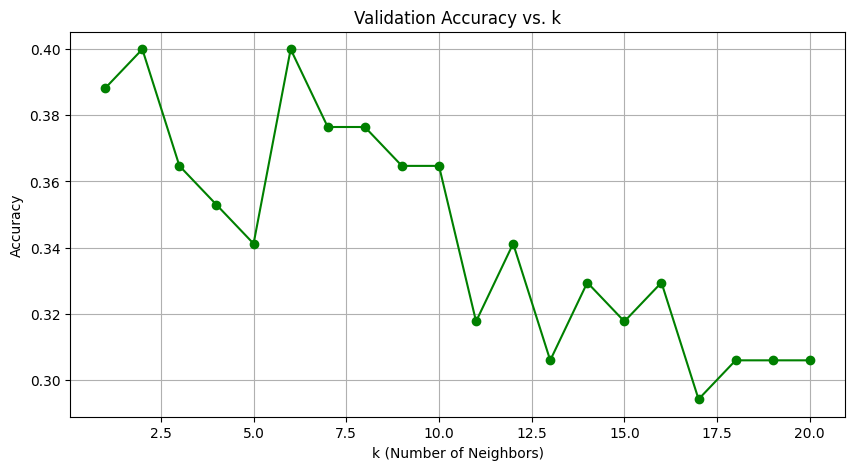

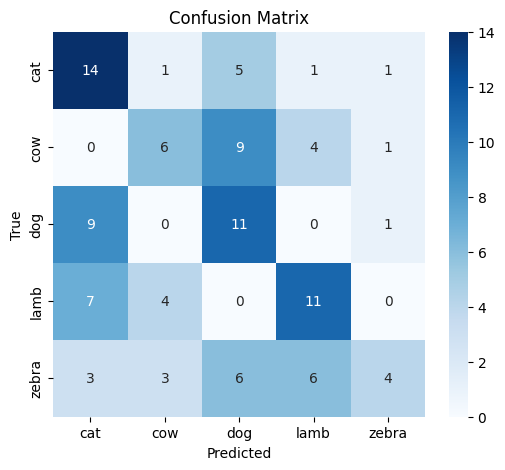

In [1]:
# 📦 Library Imports
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 📂 Dataset Setup
data_dir = '/kaggle/input/animal-images/dataset'
categories = ['cat', 'cow', 'dog', 'lamb', 'zebra']
image_size = 64  # ✅ Changed from 128 to 64

X = []
y = []

# 🖼️ Load and Preprocess Images
for category in categories:
    folder_path = os.path.join(data_dir, category)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0  # Normalize
            X.append(img.flatten())  # Flatten to 1D
            y.append(category)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

X = np.array(X)
y = np.array(y)

# 🔤 Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 🔀 Split into Train (64%), Validation (16%), Test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# 📉 Apply PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Original shape: {X_train.shape}")
print(f"Reduced shape after PCA: {X_train_pca.shape}")

# 🔍 Hyperparameter Tuning on Validation Set
val_accuracies = []
print("\n🔧 Validation Accuracy for Different k:")
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    val_pred = knn.predict(X_val_pca)
    acc = accuracy_score(y_val, val_pred)
    val_accuracies.append(acc)
    print(f"k={k} --> Validation Accuracy: {acc:.2f}")

# 🏆 Final Model using Best k
best_k = np.argmax(val_accuracies) + 1
print(f"\n✅ Best k = {best_k}")

# Retrain on Train + Validation sets
X_train_val_pca = pca.transform(X_train_val)
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_val_pca, y_train_val)

# 📊 Evaluate on Test Set
y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 📈 Plot Accuracy vs. k
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), val_accuracies, marker='o', color='green')
plt.title('Validation Accuracy vs. k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 🔍 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
